In [1]:
import re
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.model_selection import train_test_split

2024-04-12 02:37:03.193040: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 02:37:03.844572: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
txt_file = 'data/eng_elec_bigram.txt'
raw_corpus = []

with open(txt_file, 'r', encoding = 'utf-8') as f:
    raw = f.read().splitlines()
    raw_corpus.extend(raw)
print(len(raw_corpus))

136330


In [7]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()                         #소문자 변경 후 양쪽 공백 제거
    sentence = re.sub(r"([?.!,¿]).,", r" \1 ", sentence)          #특수문자 양쪽에 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence)                 #여러 개의 공백이 붙어있으면 하나의 공백으로
    sentence = re.sub(r"[^a-zA-Z가-힣?!¿_]+", " ", sentence)   #영어, 알파벳, ?, !, ¿ 제외 모두 공백으로
    sentence = sentence.strip()                                 #양쪽 공백 제거
    sentence = re.sub(r"\(.\)", " ", sentence)                  #괄호 제거
    sentence = '<start> ' + sentence + ' <end>'                 #start, end 추가
    return sentence

In [8]:
corpus = []
for sentence in raw_corpus:
    if len(sentence) == 0:
        continue
    if sentence[-1] == ':':
        continue
    if len(sentence)>150:
        continue
    
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
    
print(len(corpus))
print(corpus[:10])

136303
['<start> ooh i can t pretend <end>', '<start> like you didn t bring <end>', '<start> my tempo up again <end>', '<start> tempo up again <end>', '<start> my head s in a spin <end>', '<start> you send my body to a place <end>', '<start> it s never been <end>', '<start> baby won t you let me <end>', '<start> keep you up all night <end>', '<start> let the morning come closer <end>']


In [9]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 25000, filters = ' ', oov_token = '<unk>')
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post')
    print('토크나이저: ', tokenizer, '\n', tensor)
    
    return tensor, tokenizer

In [10]:
tensor, tokenizer = tokenize(corpus)

토크나이저:  <keras.src.legacy.preprocessing.text.Tokenizer object at 0x7f2ee9862390> 
 [[   2   84    4 ...    0    0    0]
 [   2   29    5 ...    0    0    0]
 [   2   13 2610 ...    0    0    0]
 ...
 [   2 6682  258 ...    0    0    0]
 [   2    4    4 ...    0    0    0]
 [   2 2461    3 ...    0    0    0]]


In [11]:
tensor.shape

(136303, 31)

In [12]:
for idx in tokenizer.index_word:
    print(idx, ':', tokenizer.index_word[idx])
    if idx>=20: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : you
6 : the
7 : me
8 : it
9 : to
10 : t
11 : and
12 : we
13 : my
14 : a
15 : m
16 : in
17 : s
18 : your
19 : that
20 : don


In [13]:
#소스 문장과 타겟 문장으로 1차 분리
#tensor에서 마지막 토큰을 잘라내어 소스 문장을, 첫번째 start를 잘라내어 타겟 문장을 생성
#LSTM에서 many-to-many의 답을 얻을 것이므로 위와 같이 구성 <- ????
#이 과정을 통해 src_input과 tgt_input 길이 동일
src_input = tensor[:, :-1]      #start+sentence+end+padding n-1개
tgt_input = tensor[:, 1:]       #sentence+end+padding n개
print('텐서 길이: ', tensor.shape)
print('소스문장 길이: ', len(src_input[0]))
print('타겟문장 길이: ', len(tgt_input[0]))

텐서 길이:  (136303, 31)
소스문장 길이:  30
타겟문장 길이:  30


In [14]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size = 0.2, random_state = 1234)
print('Source Train 길이: ', enc_train.shape)
print('Target Train 길이: ', dec_train.shape)
print('Source Test 길이: ', enc_val.shape)
print('Target Test 길이: ', dec_val.shape)

Source Train 길이:  (109042, 30)
Target Train 길이:  (109042, 30)
Source Test 길이:  (27261, 30)
Target Test 길이:  (27261, 30)


In [15]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epochs = len(src_input) // BATCH_SIZE
VOCAB_SIZE = tokenizer.num_words + 1

dataset_train = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset_train = dataset_train.shuffle(BUFFER_SIZE)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder = True)

dataset_val = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
dataset_val = dataset_val.shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder = True)

print(dataset_train)
print(dataset_val)

2024-04-12 02:37:46.785463: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 02:37:46.822488: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 02:37:46.822664: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

<_BatchDataset element_spec=(TensorSpec(shape=(256, 30), dtype=tf.int32, name=None), TensorSpec(shape=(256, 30), dtype=tf.int32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(256, 30), dtype=tf.int32, name=None), TensorSpec(shape=(256, 30), dtype=tf.int32, name=None))>


In [16]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)      #vocab_size로 입력되어서 그걸 embedding_size 만큼으로 표현할 것
        self.rnn_1 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences = True)
        self.rnn_2 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences = True)
        self.linear = tf.keras.layers.Dense(vocab_size)     #vocab_size로 줄여야 다음에 무슨 단어를 낼지에 대한 각 클래스 별 수치가 출력
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

In [17]:
embedding_size = 256    #word embedding 차원 수. 즉, 단어가 추상적으로 표현되는 크기 -> dataset의 shape과 같아야 하는거 아닌지???
hidden_size = 1024      #hidden state의 차원 수
model = TextGenerator(tokenizer.num_words + 1, embedding_size, hidden_size)
model

<TextGenerator name=text_generator, built=False>

In [18]:
for src_sample, tgt_sample in dataset_train.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 30, 25001), dtype=float32, numpy=
array([[[-0.00287937, -0.00266355,  0.00320496, ..., -0.00991148,
          0.00674765, -0.01009085],
        [-0.00273297,  0.00386189, -0.01205425, ...,  0.02155753,
         -0.00233432, -0.01630219],
        [ 0.02242805,  0.00879456, -0.02532077, ...,  0.00198452,
          0.00383248,  0.00568067],
        ...,
        [-0.09040245, -0.02438269,  0.07135586, ..., -0.1379161 ,
          0.09901794, -0.02128337],
        [-0.11488926,  0.01514099, -0.01359809, ..., -0.07003986,
          0.02550394, -0.03401102],
        [-0.01418668, -0.02365244, -0.01379749, ..., -0.12906994,
          0.04160269,  0.02670025]],

       [[-0.00287937, -0.00266355,  0.00320496, ..., -0.00991148,
          0.00674765, -0.01009085],
        [ 0.00235034,  0.01520302,  0.00612536, ...,  0.01093664,
         -0.00153772, -0.01536118],
        [-0.00075478,  0.01248283,  0.00076026, ...,  0.00798752,
          0.00821647, -0.00790612],
        .

In [19]:
model.summary()

Model: "text_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     6,400,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │    25,626,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,436,201 (135.18 MB)

 Trainable params: 35,436,201 (135.18 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-04-12 02:37:59.053971: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 02:37:59.054165: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 02:37:59.054263: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

True

L355
2024-04-12 02:37:59.054534: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 02:37:59.054648: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:0 with 12702 MB memory:  -> device: 0, name: NVIDIA A16-16Q, pci bus id: 0000:06:00.0, compute capability: 8.6


In [21]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')

In [22]:
model.compile(loss = loss, optimizer = optimizer)
model.fit(dataset_train, epochs = 10)

Epoch 1/10


I0000 00:00:1712889483.598761  507246 service.cc:145] XLA service 0x7f2e20005a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712889483.598809  507246 service.cc:153]   StreamExecutor device (0): NVIDIA A16-16Q, Compute Capability 8.6
2024-04-12 02:38:03.649755: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-12 02:38:04.144083: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1712889484.571687  507310 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_61', 84 bytes spill stores, 84 bytes spill loads

I0000 00:00:1712889485.046813  507311 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_61', 1740 bytes spill stores, 2152 bytes spill loads

I0000 00:00:1712889

425/425 ━━━━━━━━━━━━━━━━━━━━ 150s 332ms/step - loss: 1.7560
Epoch 2/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 141s 331ms/step - loss: 1.0151
Epoch 3/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 141s 331ms/step - loss: 0.9311
Epoch 4/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 141s 331ms/step - loss: 0.8796
Epoch 5/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 141s 331ms/step - loss: 0.8377
Epoch 6/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 141s 331ms/step - loss: 0.7976
Epoch 7/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 141s 331ms/step - loss: 0.7633
Epoch 8/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 141s 331ms/step - loss: 0.7314
Epoch 9/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 141s 331ms/step - loss: 0.7178
Epoch 10/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 141s 331ms/step - loss: 0.6852


In [23]:
model.save('rnn_eng_elec_bigram.keras')
model.save('rnn_eng_elec_bigram.h5')
tf.saved_model.save(model, 'rnn_eng_elec_bigram.tf')

INFO:tensorflow:Assets written to: rnn_eng_elec_bigram.tf/assets


INFO:tensorflow:Assets written to: rnn_eng_elec_bigram.tf/assets


In [24]:
def generate_text(model, tokenizer, init_sentence = '<start>', max_len = 30):
    #테스트를 위해 입력받은 init_sentence도 텐서 변환
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype = tf.int64)
    end_token = tokenizer.word_index['<end>']
    
    #단어를 하나씩 예측해 문장 생성
    while True:
        #1. 입력받은 문장의 텐서 입력
        predict = model(test_tensor)
        #2. 예측된 값 중 가장 높은 확률인 word index를 출력
        predict_word = tf.argmax(tf.nn.softmax(predict, axis = -1), axis = -1)[:, -1]
        #3. 2에서 예측된 word index를 문장 뒤에 붙임
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis = 0)], axis = -1)
        #4. 모델이 <end>를 예측했거나 max_len에 도달하면 문장 생성을 마침
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break
        
    generated = ''
    #tokenizer를 활용해 word index를 단어로 하나씩 변환
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + ' '
        
    return generated

In [25]:
generate_text(model, tokenizer, init_sentence = '<start> i')

'<start> i m not gonna make it <end> '

In [26]:
generate_text(model, tokenizer, init_sentence = '<start> i', max_len = 50)

'<start> i m not gonna make it <end> '

In [27]:
generate_text(model, tokenizer, init_sentence = '<start> i love')

'<start> i love you <end> '

In [28]:
generate_text(model, tokenizer, init_sentence = '<start> love')

'<start> love me now <end> '

In [29]:
generate_text(model, tokenizer, init_sentence = '<start> Love is')

'<start> love is love is love <end> '

In [30]:
generate_text(model, tokenizer, init_sentence = '<start> love you ')

'<start> love you better_than me <end> '

electronica_die trying - aespa, tokimonsta

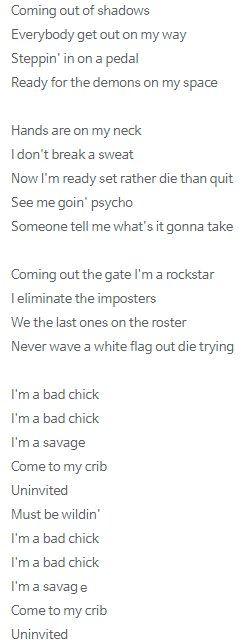

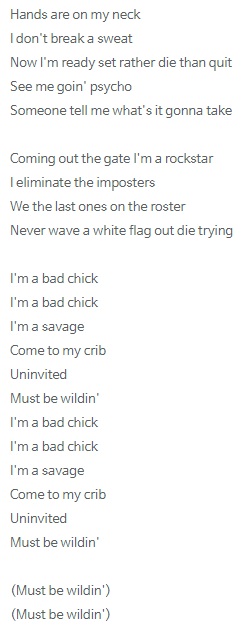

In [31]:
die_trying = ['coming', 'everybody', 'steppin', 'ready', 'hands', 'i', 'now', 'see', 'someone', 'we']
for word in die_trying:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> coming back to you <end> 
<start> everybody s a beast <end> 
<start> steppin up for me <end> 


<start> ready to keep you warm <end> 
<start> hands up the bass <end> 
<start> i m not gonna make it <end> 
<start> now i m not alone <end> 
<start> see the signs <end> 
<start> someone to hold on <end> 
<start> we re freeing our_souls <end> 


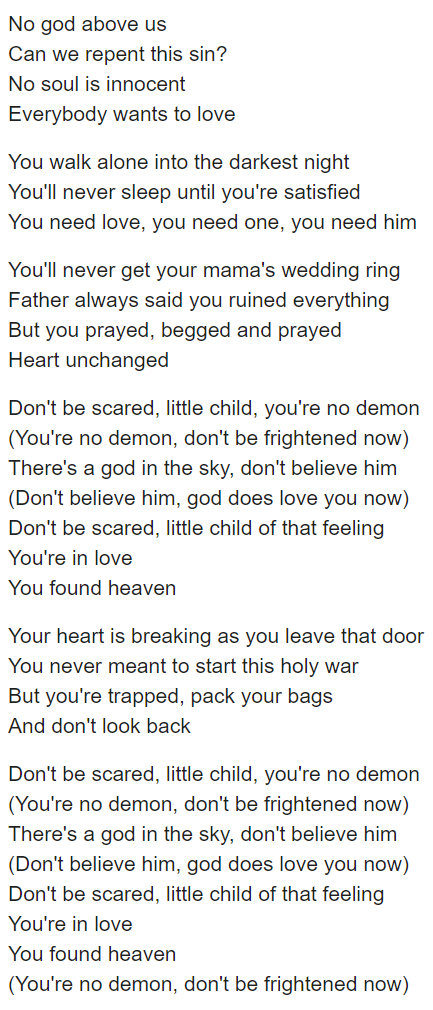

all genre

In [32]:
found_heaven = ['no', 'can', 'everybody', 'you', 'father', 'but', 'heart', 'don', 'there', 'your']
for word in found_heaven:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> no one_else makes me feel alive <end> 
<start> can t get enough <end> 
<start> everybody s a beast <end> 


<start> you re just a_bunch of_freaks <end> 
<start> father said i m not alone <end> 
<start> but i m not gonna make you <end> 
<start> heart is running_wild <end> 
<start> don t you hold me down <end> 
<start> there s a place for your love <end> 
<start> your love love your love <end> 


: 